In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix,csr_matrix,eye,bmat
from scipy.sparse.linalg import eigs,inv,gmres
from scipy.stats import norm
%matplotlib inline

In [2]:
data = pd.read_csv('data/round.csv').drop('Unnamed: 0',axis=1)

In [3]:
data.head()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
0,2003,10,16,656,1320,"Estes, Bob",1,11:50,66,T6,7.5,0.197917
1,2003,10,16,656,1361,"Forsman, Dan",1,11:00,69,T21,22.0,0.600694
2,2003,10,16,656,1761,"Mattiace, Len",1,13:00,75,24,24.0,0.656250
3,2003,10,16,656,1797,"Mediate, Rocco",1,12:10,72,T2,2.5,0.059028
4,2003,10,16,656,1920,"Parry, Craig",1,11:20,71,T25,26.5,0.725694


In [4]:
data.shape

(249822, 12)

In [5]:
data.tail()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
249817,2016,340,26,608,40098,"Fitzpatrick, Matthew",4,10:20,71,T54,55.0,0.494344
249818,2016,340,26,608,46970,"Rahm, Jon",4,11:50,70,T23,27.0,0.240950
249819,2016,340,26,608,47287,"Tracy, Ethan",4,10:10,77,T65,65.5,0.589367
249820,2016,340,26,608,47959,"DeChambeau, Bryson",4,14:50,74,T15,16.0,0.141403
249821,2016,340,26,608,50490,"Parker, Chase",4,11:50,81,64,64.0,0.575792


In [6]:
inds = {num:ind for ind,num in enumerate(pd.unique(data.Player_Number))}

In [7]:
data.insert(5,'Player_Index',[inds[num] for num in data.Player_Number])

In [8]:
rounds = data.groupby(['Tournament_Year','Permanent_Tournament_#','Round_Number','Course_#'])

In [9]:
n_players = len(pd.unique(data.Player_Index))
n_rounds = len(rounds)
n_tournaments = len(data.groupby(['Tournament_Year','Permanent_Tournament_#']))

In [10]:
print n_players,n_rounds,n_tournaments

2551 2754 612


In [11]:
def load_sparse_csc(filename):
    loader = np.load(filename)
    return csc_matrix((loader['data'],loader['indices'],loader['indptr']),shape = loader['shape'])

In [12]:
def my_norm(x,BETA):
    return norm.pdf(x,0,BETA)/norm.pdf(0,0,BETA)

In [13]:
def inflate(tournament_group,rounds_to_inflate,n_tournament_groups,BETA,window_size=28):
    mat = csc_matrix((n_players*n_tournament_groups,n_players),dtype=float)
    mat_1 = csc_matrix((n_players*n_tournament_groups,n_players),dtype=float)
    for j in rounds_to_inflate:
        mat += bmat([[load_sparse_csc('rounds/%d.npz' % j)*my_norm(tournament_group-k,BETA)] for k in range(1,n_tournament_groups+1)],format='csc')
        mat_1 += bmat([[(load_sparse_csc('rounds/%d.npz' % j)!=0).astype(float)*my_norm(tournament_group-k,BETA)] for k in range(1,n_tournament_groups+1)],format='csc')
    if tournament_group>window_size:
        del inflate.__dict__[tournament_group-window_size]
    inflate.__dict__[tournament_group] = (mat,mat_1)
    out_mat = bmat([[inflate.__dict__[i][0][max(0,tournament_group-window_size)*n_players:n_players*tournament_group] for i in range(max(1,tournament_group-window_size+1),tournament_group+1)]],format='csc')
    out_mat1 = bmat([[inflate.__dict__[i][1][max(0,tournament_group-window_size)*n_players:n_players*tournament_group] for i in range(max(1,tournament_group-window_size+1),tournament_group+1)]],format='csc')
    return (out_mat,out_mat1)

In [14]:
def alpha(A,a):
    A.data[A.data<1e-6] = 0
    A.data[np.isnan(A.data)]=0
    w,v = eigs(A,k=1,which='LM')
    return a/w[0].real

In [15]:
def solve(mat,mat_1,a,min_reps,x_guess=None,x_guess1=None):
    mat.data[mat_1.data<1e-6] = 0
    mat_1.data[mat_1.data<1e-6] = 0
    mat.data[np.isnan(mat.data)] = 0
    mat_1.data[np.isnan(mat_1.data)] = 0
    
    S = eye(mat.shape[0],format='csc')-alpha(mat,a)*mat
    w_a = gmres(S,mat.sum(1),x0=x_guess)[0]
    
    S = eye(mat_1.shape[0],format='csc')-alpha(mat_1,a)*mat_1 
    w_g = gmres(S,mat_1.sum(1),x0=x_guess1)[0]
    
    w_a[w_g<min_reps]=0
    solve.w_a = w_a
    solve.w_g = w_g
    
    return ((w_a/w_g)[-n_players:],w_g[-n_players:])

In [16]:
ranks,reps = [],[]
BETA = 6
a = .8
bin_size = 4
window_size = 28
n_tournament_groups = int(math.ceil(n_tournaments/float(bin_size)))
current_group = 0
tournament_groups=[set()]
tournaments = set()
rounds_to_inflate = []
for round_ind,df in enumerate(rounds):
    df = df[1]
    tournament_groups[current_group].add(','.join(map(str,[df.iloc[0].Tournament_Year,df.iloc[0]['Permanent_Tournament_#']])))
    tournaments.add(','.join(map(str,[df.iloc[0].Tournament_Year,df.iloc[0]['Permanent_Tournament_#']])))
    tournament_group = len(tournaments)/bin_size
    rounds_to_inflate.append(round_ind)
    if tournament_group>current_group:
        A,G = inflate(tournament_group,rounds_to_inflate,n_tournament_groups,BETA)
        if current_group==0:
            res = solve(A,G,a,1)
            ranks.append(res[0])
            reps.append(res[1])
            print 'Tournament Group %d done' % tournament_group
            current_group = tournament_group
            tournament_groups.append(set())
            rounds_to_inflate = []
        else:
            w_a_approx = np.append(solve.w_a[0 if tournament_group<=window_size else n_players:],solve.w_a[-n_players:])
            w_g_approx = np.append(solve.w_g[0 if tournament_group<=window_size else n_players:],solve.w_g[-n_players:])
            res = solve(A,G,a,1,w_a_approx,w_g_approx)
            ranks.append(res[0])
            reps.append(res[1])
            print 'Tournament Group %d done' % tournament_group
            current_group = tournament_group
            tournament_groups.append(set())
            rounds_to_inflate = []

Tournament Group 1 done
Tournament Group 2 done
Tournament Group 3 done
Tournament Group 4 done
Tournament Group 5 done
Tournament Group 6 done
Tournament Group 7 done
Tournament Group 8 done
Tournament Group 9 done
Tournament Group 10 done
Tournament Group 11 done
Tournament Group 12 done
Tournament Group 13 done
Tournament Group 14 done
Tournament Group 15 done
Tournament Group 16 done
Tournament Group 17 done
Tournament Group 18 done
Tournament Group 19 done
Tournament Group 20 done
Tournament Group 21 done


KeyboardInterrupt: 

In [17]:
master_df = pd.DataFrame({'Player_Index':[],'Permanent_Tournament_#':[],'Course_#':[],
                          'Finishing_Pct':[],'Rating':[],'Reps':[],'Pct_Reps':[]})
for j in range(len(ranks)):
    df = pd.DataFrame({'player_ind':range(n_players),
                       'rank':ranks[j],
                       'reps':reps[j]}).dropna()
    pct_reps = pd.Series(df.reps[df.reps!=0]).rank(pct=True)
    df.insert(len(df.columns),'pct_reps',[0]*len(df))
    df.ix[df.reps!=0,'pct_reps'] = pct_reps
    rank_dict,reps_dict,pct_reps_dict = df['rank'].to_dict(),df['reps'].to_dict(),df['pct_reps'].to_dict()
    years = [int(i.split(',')[0]) for i in tournament_groups[j+1]]
    t_ids = [int(i.split(',')[1]) for i in tournament_groups[j+1]]
    df2 = data[data['Tournament_Year'].isin(years) & data['Permanent_Tournament_#'].isin(t_ids)]
    grouped = df2.groupby(['Player_Index','Permanent_Tournament_#','Course_#'],as_index=False)
    df3 = grouped['Finishing_Pct'].mean()
    df3['Rating'] = df3['Player_Index'].map(rank_dict)
    df3['Reps'] = df3['Player_Index'].map(reps_dict)
    df3['Pct_Reps'] = df3['Player_Index'].map(pct_reps_dict)
    master_df = pd.concat([master_df,df3])

master_df = master_df.dropna()

In [18]:
master_df.head(5)

,Course_#,Finishing_Pct,Pct_Reps,Permanent_Tournament_#,Player_Index,Rating,Reps
0,4,0.279867,0.033755,4,0,0.999290,330.208134
1,104,0.279867,0.033755,4,0,0.999290,330.208134
2,500,0.116898,0.033755,7,0,0.999290,330.208134
3,6,0.114773,0.983122,6,1,1.023616,5282.206363
4,500,0.116898,0.983122,7,1,1.023616,5282.206363


In [95]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

ols = LinearRegression()

In [19]:
np.corrcoef(master_df.Rating,master_df.Finishing_Pct)

array([[ 1.        , -0.35883498],
       [-0.35883498,  1.        ]])

In [21]:
len(master_df)

16619

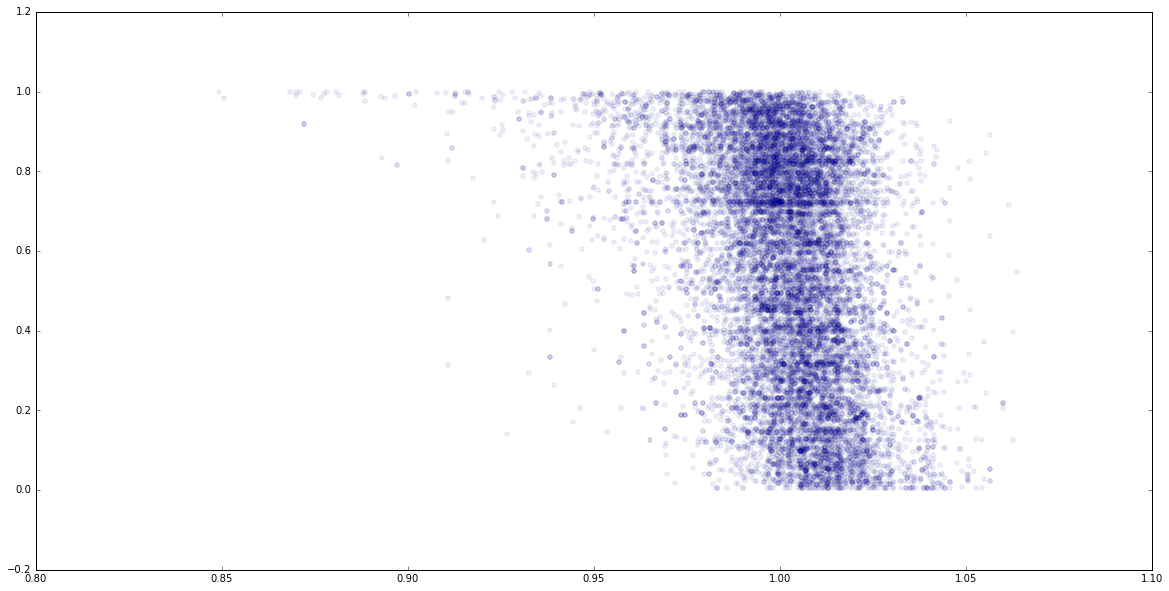

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(master_df.Rating,master_df.Finishing_Pct,alpha=.07);

In [97]:
X,y = master_df.Rating.values,master_df.Finishing_Pct.values

In [63]:
ols.fit(X[:,None],y)
print ols.intercept_,ols.coef_[0]

6.51135572494 -5.94145952278


In [64]:
ols.fit(X[:,None],y,sample_weight=master_df.Reps)
print ols.intercept_,ols.coef_[0]

8.48050744799 -7.90376167719


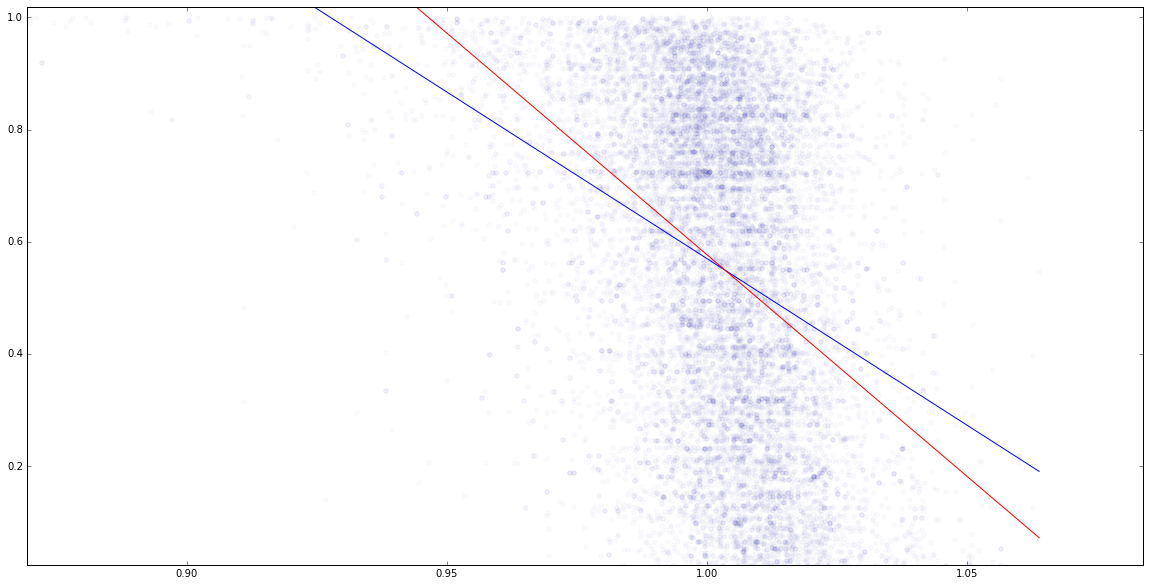

In [45]:
ols.fit(X[:,None],y)
predictions_u = ols.predict(np.sort(X)[:,None])
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(X,y,alpha=.02)
plt.plot(np.sort(X),predictions_u,c='b')
ols.fit(X[:,None],y,sample_weight=master_df.Reps)
predictions_w = ols.predict(np.sort(X)[:,None])
plt.plot(np.sort(X),predictions_w,c='r')
plt.xlim(X.min()+.02,X.max()+.02);
plt.ylim(y.min()+.02,y.max()+.02);

In [70]:
ols.fit(X[:,None],y,sample_weight=master_df.Reps)
residuals = ols.predict(X[:,None]) - y
np.corrcoef(residuals,master_df.Reps)

array([[ 1.        , -0.02227357],
       [-0.02227357,  1.        ]])

In [90]:
squared_residuals = (ols.predict(X[:,None]) - y)**2
weighted_squared_residuals = squared_residuals * master_df.Reps.values / master_df.Reps.sum()
RMWSR = np.mean(weighted_squared_residuals)**.5

In [93]:
RMWSR

0.0021116823889155006

In [100]:
kfold = KFold(len(y),n_folds=10,shuffle=True)
scores = []
for train,test in kfold:
    ols.fit(X[train,None],y[train],sample_weight=master_df.Reps.values[train])
    predictions = ols.predict(X[test,None])
    squared_residuals = (predictions - y[test])**2
    weighted_squared_residuals = squared_residuals * master_df.Reps.values[test] / master_df.Reps.values[test].sum()
    RMWSR = np.mean(weighted_squared_residuals)**.5
    scores.append(RMWSR)
print np.mean(scores),np.std(scores),np.mean(scores)+np.std(scores)/10**.5

0.00667804590585 9.66755461517e-05 0.00670861739784


In [34]:
X = sm.add_constant(X)

In [35]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Finishing_Pct   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     2456.
Date:                Thu, 01 Sep 2016   Prob (F-statistic):               0.00
Time:                        17:12:11   Log-Likelihood:                -1897.9
No. Observations:               16619   AIC:                             3800.
Df Residuals:                   16617   BIC:                             3815.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.5114      0.120     54.209      0.0

In [89]:
poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(X)

In [90]:
cross_val_score(ols,X,y,cv=10).mean()

0.2423266785750664

In [135]:
X.shape

(13645, 3)

In [50]:
print n_round_groups
print S.shape[0]**2

7
1768900


In [51]:
print len(S.nonzero()[1])/float(S.shape[0]**2)

0.15487704223


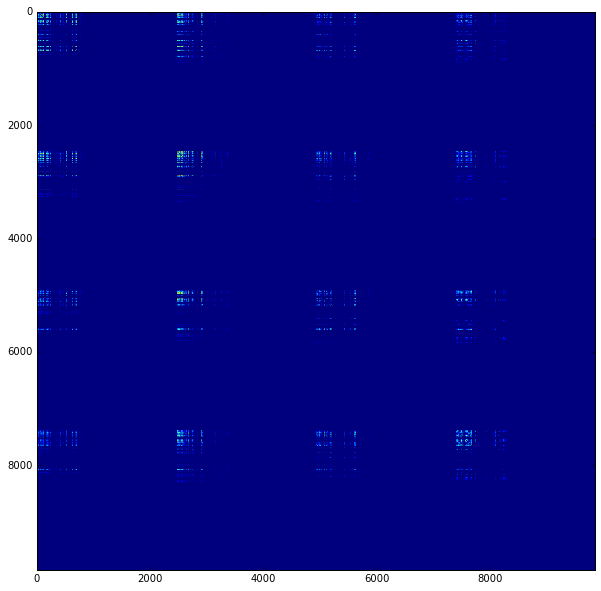

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(A[10*n_players:14*n_players,10*n_players:14*n_players].toarray());

In [156]:
pd.DataFrame({'player_ind':range(n_players),
              'player_name':[inds_to_name[i] for i in range(n_players)],
              'rank':ranks[0]}).sort_values('rank',ascending=False).dropna()

,player_ind,player_name,rank
13,13,"Singh, Vijay",1.059954
45,45,"Faxon, Brad",1.056565
27,27,"Goosen, Retief",1.048116
180,180,"Weir, Mike",1.045884
162,162,"Mickelson, Phil",1.043698
30,30,"Rollins, John",1.041482
49,49,"Huston, John",1.040823
33,33,"Donald, Luke",1.038114
84,84,"Wilson, Dean",1.037730
82,82,"Lickliter II, Frank",1.037002


In [ ]:
inds_to_name = {i:data[data.Player_Index==i].iloc[0].Player_Name for i in range(n_players)}

In [91]:
names_to_ind = {inds_to_name[key]:key for key in inds_to_name}

In [185]:
inds_to_plot = [names_to_ind['Johnson, Dustin'],
                names_to_ind['Mickelson, Phil']]

#names_to_ind['Woods, Tiger'],names_to_ind['Day, Jason'],names_to_ind['Donald, Luke']
#names_to_ind['Stricker, Steve'],names_to_ind['Spieth, Jordan'],

In [186]:
from numpy import trapz

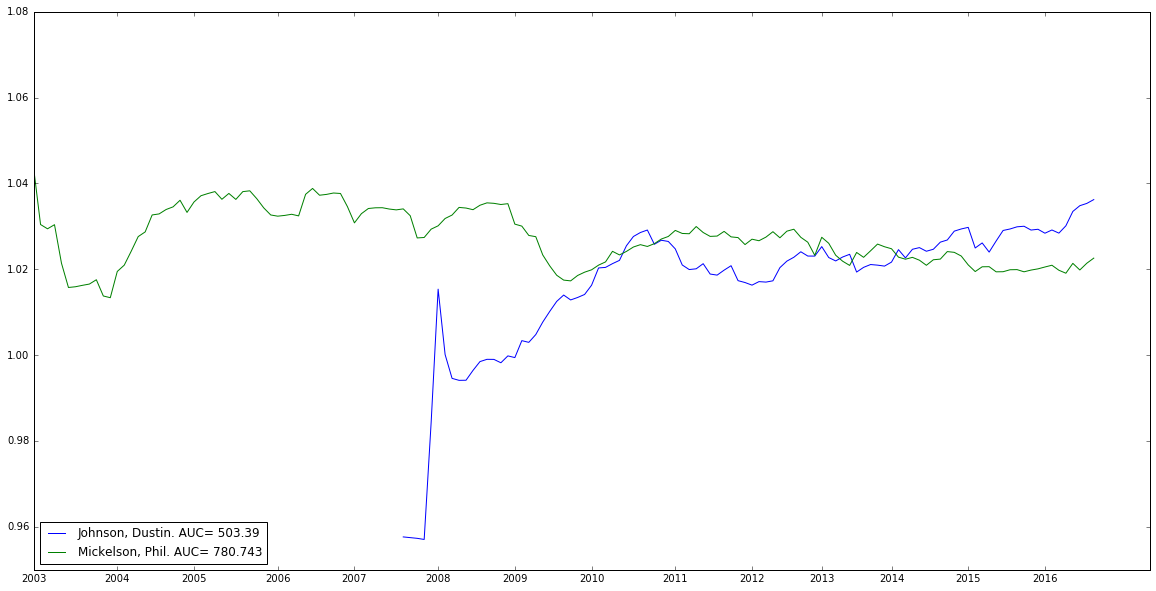

In [187]:
fig, ax = plt.subplots(figsize=(20, 10))
for j in inds_to_plot:
    y = np.array([ranks[i][j] for i in range(len(ranks))])
    y = y[np.logical_not(np.isnan(y))]
    area = trapz(y, dx=5)
    plt.plot([ranks[i][j] for i in range(len(ranks))],label = inds_to_name[j]+'. AUC= %g' % area);
plt.legend(loc=3);
plt.xticks([i[1] for i in year_inds], [i[0] for i in year_inds]);
plt.ylim(.95,1.08);

In [102]:
year_inds = [max([map(int,[i.split(',')[0] for i in j])]) for j in tournament_groups]

In [103]:
from collections import Counter
year_inds = [Counter(i) for i in year_inds]

In [104]:
year_inds = [sorted(i,key=year_inds[u].get,reverse=True)[0] for u,i in enumerate(year_inds)]

In [105]:
year_inds = np.array(year_inds)
year_inds = [(year,np.argwhere(year_inds==year).min()) for year in range(2003,2017)]

In [106]:
year_inds

[(2003, 0),
 (2004, 12),
 (2005, 23),
 (2006, 35),
 (2007, 46),
 (2008, 58),
 (2009, 69),
 (2010, 80),
 (2011, 92),
 (2012, 103),
 (2013, 113),
 (2014, 123),
 (2015, 134),
 (2016, 145)]